Epoch 1/50, Loss: 0.1084
Epoch 2/50, Loss: 0.0518
Epoch 3/50, Loss: 0.0425
Epoch 4/50, Loss: 0.0410
Epoch 5/50, Loss: 0.0386
Epoch 6/50, Loss: 0.0378
Epoch 7/50, Loss: 0.0379
Epoch 8/50, Loss: 0.0366
Epoch 9/50, Loss: 0.0368
Epoch 10/50, Loss: 0.0364
Epoch 11/50, Loss: 0.0358
Epoch 12/50, Loss: 0.0362
Epoch 13/50, Loss: 0.0356
Epoch 14/50, Loss: 0.0359
Epoch 15/50, Loss: 0.0355
Epoch 16/50, Loss: 0.0357
Epoch 17/50, Loss: 0.0349
Epoch 18/50, Loss: 0.0356
Epoch 19/50, Loss: 0.0345
Epoch 20/50, Loss: 0.0350
Epoch 21/50, Loss: 0.0351
Epoch 22/50, Loss: 0.0346
Epoch 23/50, Loss: 0.0341
Epoch 24/50, Loss: 0.0346
Epoch 25/50, Loss: 0.0350
Epoch 26/50, Loss: 0.0350
Epoch 27/50, Loss: 0.0337
Epoch 28/50, Loss: 0.0338
Epoch 29/50, Loss: 0.0334
Epoch 30/50, Loss: 0.0329
Epoch 31/50, Loss: 0.0333
Epoch 32/50, Loss: 0.0335
Epoch 33/50, Loss: 0.0336
Epoch 34/50, Loss: 0.0339
Epoch 35/50, Loss: 0.0339
Epoch 36/50, Loss: 0.0330
Epoch 37/50, Loss: 0.0329
Epoch 38/50, Loss: 0.0337
Epoch 39/50, Loss: 0.

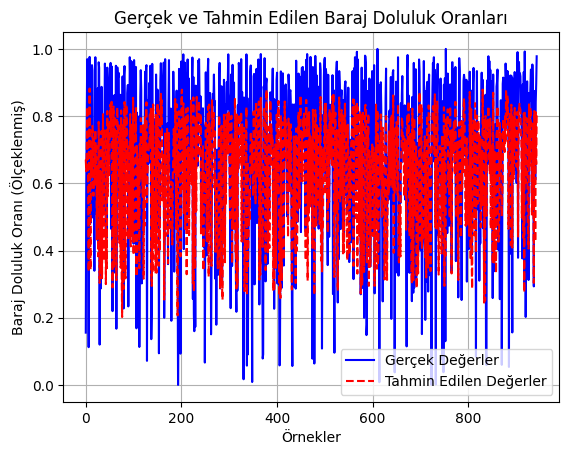

In [1]:
# FEDFORMER MODELİ
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
# Excel verilerini yükleme
data = pd.read_excel('ömerliBarajı.xlsx')
data['tarih'] = pd.to_datetime(data['tarih'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['sıcaklık', 'çiy', 'nem', 'yağış',
            'ruzgar hızı', 'deniz seviyesi basıncı', 'bulutortusu', 'daylight_duration']
target = 'doluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırın
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, :-1]
        label = data[i + seq_length, -1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 30  # 30 günlük geçmiş veri kullanacağız
data_array = data[features + [target]].values
X, y = create_sequences(data_array, seq_length)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# FEDformer modelini tanımlayın
class FEDformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FEDformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Son zaman adımını alın
        out = self.fc(out)
        return out

# Model oluşturma
input_size = len(features)
hidden_size = 64
output_size = 1

model = FEDformer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(output.numpy())

# Hesaplamalar
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)


epsilon = 1e-5  # Çok küçük bir değer
valid_indices = y_true > epsilon  # Sadece bu koşulu sağlayanları al
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]

# Filtrelenmiş değerler ile MAPE hesaplaması
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Modelin tahmin yapması
def predict(data, model, scaler, seq_length):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[-seq_length:, :-1].reshape(1, seq_length, -1), dtype=torch.float32)
        prediction = model(inputs).item()
    return scaler.inverse_transform([[0] * (len(features)) + [prediction]])[0, -1]
    plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()



Sayısal sütunlar: Index(['sıcaklık', 'çiy', 'nem', 'yağış', 'ruzgar hızı',
       'deniz seviyesi basıncı', 'bulutortusu', 'daylight_duration',
       'doluluk'],
      dtype='object')


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 1/10, Train Loss: 0.1660318694387873, Test Loss: 0.027886847922529438
Train MSE: 0.16605332077052495, Test MSE: 0.02852172988082504
Train MAPE: inf%, Test MAPE: 36.19132339954376%
Train MAE: 0.32022508033153163, Test MAE: 0.14338294721057274
Train RMSE: 0.40749640583755453, Test RMSE: 0.16888377625108056
Train R²: -1.384608916217875, Test R²: -0.07482914878084501
Training Time: 54.60149955749512 seconds, Inference Time: 3.0079894065856934 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 2/10, Train Loss: 0.13685912531973035, Test Loss: 0.06382356476234763
Train MSE: 0.13752459977412979, Test MSE: 0.06076672226814295
Train MAPE: inf%, Test MAPE: 41.105177998542786%
Train MAE: 0.26776619418554726, Test MAE: 0.2163909242193923
Train RMSE: 0.370843093199981, Test RMSE: 0.24650907137089895
Train R²: -0.9749221834225164, Test R²: -1.2899678470617642
Training Time: 55.28174090385437 seconds, Inference Time: 2.91440486907959 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 3/10, Train Loss: 0.10587103881321296, Test Loss: 0.04626709610027702
Train MSE: 0.10655753159831909, Test MSE: 0.04422691412540161
Train MAPE: nan%, Test MAPE: 32.38525986671448%
Train MAE: 0.1779864880774442, Test MAE: 0.17805652585294512
Train RMSE: 0.32643151134398635, Test RMSE: 0.21030195939506036
Train R²: -0.5302195629719857, Test R²: -0.6666722762341044
Training Time: 55.95369577407837 seconds, Inference Time: 2.6004433631896973 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 4/10, Train Loss: 0.11918367609312688, Test Loss: 0.050344769395642766
Train MSE: 0.11866400070374325, Test MSE: 0.047914933278163784
Train MAPE: nan%, Test MAPE: 33.87218117713928%
Train MAE: 0.1850240518946454, Test MAE: 0.1881755182121554
Train RMSE: 0.3444764153084261, Test RMSE: 0.21889479956856853
Train R²: -0.7040745273819182, Test R²: -0.8056536950755957
Training Time: 55.72218298912048 seconds, Inference Time: 3.5779247283935547 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 5/10, Train Loss: 0.10974169164654557, Test Loss: 0.04528510291129351
Train MSE: 0.10961605267057375, Test MSE: 0.04363963887177984
Train MAPE: inf%, Test MAPE: 32.7946811914444%
Train MAE: 0.1707148969524678, Test MAE: 0.18093618360849528
Train RMSE: 0.3310831506896323, Test RMSE: 0.20890102649766906
Train R²: -0.5741414585745297, Test R²: -0.644541060365087
Training Time: 57.001683712005615 seconds, Inference Time: 2.6545519828796387 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 6/10, Train Loss: 0.10527610709821736, Test Loss: 0.04666969562439542
Train MSE: 0.1054058868841717, Test MSE: 0.04531992709370356
Train MAPE: nan%, Test MAPE: 35.91934144496918%
Train MAE: 0.15791338125941393, Test MAE: 0.18944845935727797
Train RMSE: 0.3246627278949213, Test RMSE: 0.21288477421765878
Train R²: -0.5136813676445575, Test R²: -0.7078620008137562
Training Time: 56.62408804893494 seconds, Inference Time: 2.0762388706207275 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 7/10, Train Loss: 0.11415703791297144, Test Loss: 0.04558096794215472
Train MSE: 0.11390683561868478, Test MSE: 0.04418011723945226
Train MAPE: inf%, Test MAPE: 33.53966474533081%
Train MAE: 0.16284528500144796, Test MAE: 0.18195979709808643
Train RMSE: 0.3375008675821216, Test RMSE: 0.21019066877350256
Train R²: -0.6357592523539202, Test R²: -0.6649087556727393
Training Time: 55.62265872955322 seconds, Inference Time: 3.378760576248169 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 8/10, Train Loss: 0.10396638276331403, Test Loss: 0.0455297070408338
Train MSE: 0.10395133980376682, Test MSE: 0.04403389086646742
Train MAPE: nan%, Test MAPE: 34.516823291778564%
Train MAE: 0.1524399384562083, Test MAE: 0.1827875668167049
Train RMSE: 0.32241485667345854, Test RMSE: 0.2098425382673099
Train R²: -0.49279334251565676, Test R²: -0.6593982775684546
Training Time: 55.056453227996826 seconds, Inference Time: 2.6813595294952393 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 9/10, Train Loss: 0.10173418988577193, Test Loss: 0.042151340111894045
Train MSE: 0.1017975044747622, Test MSE: 0.04096523854941752
Train MAPE: inf%, Test MAPE: 33.61769914627075%
Train MAE: 0.15044990848942352, Test MAE: 0.17799938555456635
Train RMSE: 0.3190572119146693, Test RMSE: 0.20239871182746574
Train R²: -0.46186318763662726, Test R²: -0.5437574320930714
Training Time: 55.54803991317749 seconds, Inference Time: 2.0527820587158203 seconds


<ipython-input-2-2ceb1348844c>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 10/10, Train Loss: 0.1047447104593394, Test Loss: 0.04402549518272281
Train MSE: 0.10490729356720006, Test MSE: 0.04302464103140389
Train MAPE: inf%, Test MAPE: 35.386091470718384%
Train MAE: 0.1513759832902959, Test MAE: 0.18456320064699547
Train RMSE: 0.3238939541998277, Test RMSE: 0.20742381982647
Train R²: -0.5065213177057775, Test R²: -0.621365130713017
Training Time: 54.32124090194702 seconds, Inference Time: 3.238807439804077 seconds


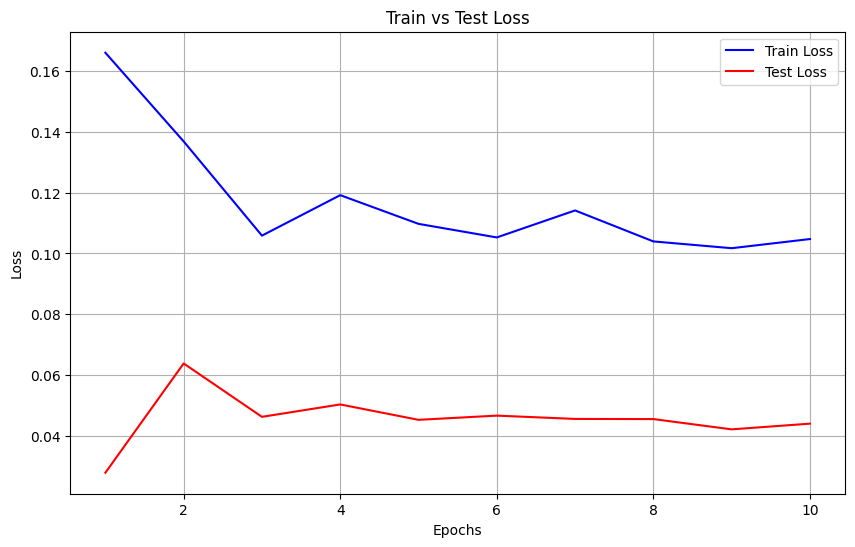

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # TFT MODELİ

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "ömerliBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['tarih'] = pd.to_datetime(data['tarih'])
data.set_index('tarih', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Yapıcı metodun doğru tanımı
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Veri setinin uzunluğunu döner
        return len(self.X)

    def __getitem__(self, index):  # Belirtilen indeks için X ve y değerlerini döner
        return self.X[index], self.y[index]

# Dataset ve DataLoader oluşturma
train_dataset = TimeSeriesDataset(X_train, y_train)  # Burada hata alınmamalı
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Düzeltildi
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 10  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.0635
Epoch 2/50, Loss: 0.0448
Epoch 3/50, Loss: 0.0423
Epoch 4/50, Loss: 0.0415
Epoch 5/50, Loss: 0.0409
Epoch 6/50, Loss: 0.0391
Epoch 7/50, Loss: 0.0391
Epoch 8/50, Loss: 0.0400
Epoch 9/50, Loss: 0.0381
Epoch 10/50, Loss: 0.0378
Epoch 11/50, Loss: 0.0387
Epoch 12/50, Loss: 0.0370
Epoch 13/50, Loss: 0.0373
Epoch 14/50, Loss: 0.0371
Epoch 15/50, Loss: 0.0367
Epoch 16/50, Loss: 0.0373
Epoch 17/50, Loss: 0.0374
Epoch 18/50, Loss: 0.0367
Epoch 19/50, Loss: 0.0363
Epoch 20/50, Loss: 0.0367
Epoch 21/50, Loss: 0.0364
Epoch 22/50, Loss: 0.0361
Epoch 23/50, Loss: 0.0365
Epoch 24/50, Loss: 0.0365
Epoch 25/50, Loss: 0.0360
Epoch 26/50, Loss: 0.0362
Epoch 27/50, Loss: 0.0361
Epoch 28/50, Loss: 0.0361
Epoch 29/50, Loss: 0.0370
Epoch 30/50, Loss: 0.0369
Epoch 31/50, Loss: 0.0360
Epoch 32/50, Loss: 0.0381
Epoch 33/50, Loss: 0.0359
Epoch 34/50, Loss: 0.0359
Epoch 35/50, Loss: 0.0362
Epoch 36/50, Loss: 0.0366
Epoch 37/50, Loss: 0.0364
Epoch 38/50, Loss: 0.0360
Epoch 39/50, Loss: 0.

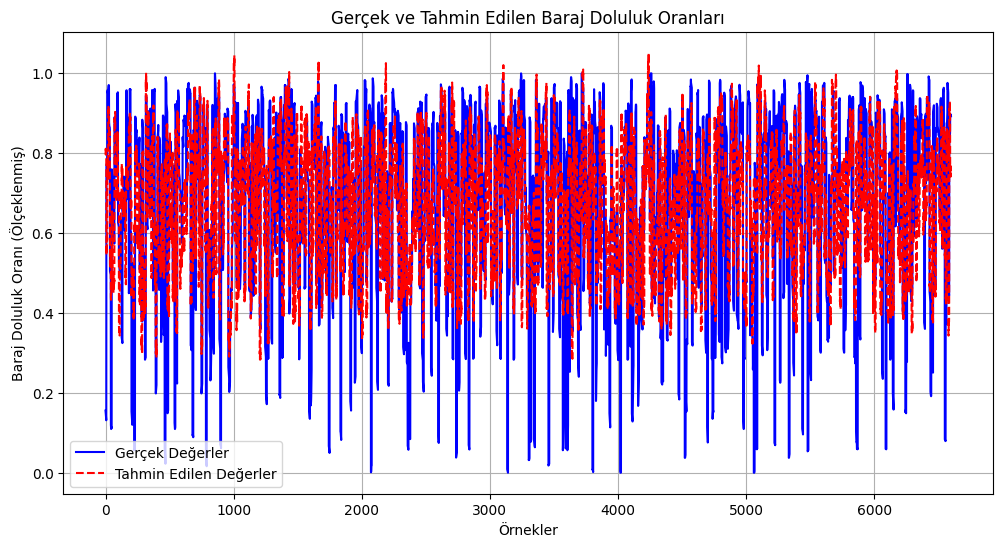

In [3]:
# İNFORMER
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Excel verilerini yükleme
data = pd.read_excel('ömerliBarajı.xlsx')
data['tarih'] = pd.to_datetime(data['tarih'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['sıcaklık', 'çiy', 'nem', 'yağış',
            'ruzgar hızı', 'deniz seviyesi basıncı', 'bulutortusu', 'daylight_duration']
target = 'doluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırma
def create_sequences(data, input_len, pred_len):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i + input_len, :-1])
        y.append(data[i + input_len:i + input_len + pred_len, -1])
    return np.array(X), np.array(y)

input_len = 30  # Geçmiş 30 gün
pred_len = 7    # Tahmin edilen 7 gün
data_array = data[features + [target]].values
X, y = create_sequences(data_array, input_len, pred_len)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Informer modeli
class Informer(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, d_model, num_heads, num_layers):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_len * input_size, pred_len)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        x = x.view(batch_size, seq_len * input_size)  # Flatten for linear layer
        x = self.fc(x)
        return x

# Model oluşturma
input_size = len(features)
d_model = 64
num_heads = 4
num_layers = 2

model = Informer(input_size, seq_len=input_len, pred_len=pred_len,
                 d_model=d_model, num_heads=num_heads, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(output.numpy().flatten())

# Performans metrikleri
# Performans metrikleri
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Tahmin ve görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()


Sayısal sütunlar: Index(['sıcaklık', 'çiy', 'nem', 'yağış', 'ruzgar hızı',
       'deniz seviyesi basıncı', 'bulutortusu', 'daylight_duration',
       'doluluk'],
      dtype='object')


<ipython-input-4-d69917c963a0>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 1/3, Train Loss: 0.05762372775966974, Test Loss: 0.0025658689142131295
Train MSE: 0.05800750364573994, Test MSE: 0.0023136452602671178
Train MAPE: inf%, Test MAPE: 8.262255787849426%
Train MAE: 0.1667214877738452, Test MAE: 0.03854541641015273
Train RMSE: 0.24084746966854342, Test RMSE: 0.048100366529446714
Train R²: 0.1669831728789758, Test R²: 0.9128112714037874
Training time for epoch 1: 64.14 seconds
Inference time for epoch 1: 0.51 seconds


<ipython-input-4-d69917c963a0>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 2/3, Train Loss: 0.001306241696443909, Test Loss: 0.0008755777120026515
Train MSE: 0.0013063313024877145, Test MSE: 0.0008472390269891202
Train MAPE: inf%, Test MAPE: 5.043012648820877%
Train MAE: 0.026938176837216974, Test MAE: 0.023531986429141116
Train RMSE: 0.036143205481635333, Test RMSE: 0.029107370664302884
Train R²: 0.9812404277313336, Test R²: 0.9680721609103786
Training time for epoch 2: 11.48 seconds
Inference time for epoch 2: 0.50 seconds


<ipython-input-4-d69917c963a0>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 3/3, Train Loss: 0.0006824368748412882, Test Loss: 0.0004997466618844651
Train MSE: 0.0006847692381822967, Test MSE: 0.0005110943888207814
Train MAPE: inf%, Test MAPE: 3.975307196378708%
Train MAE: 0.019863404985320583, Test MAE: 0.018674941781239632
Train RMSE: 0.026168095807343274, Test RMSE: 0.022607396772312847
Train R²: 0.9901663705167463, Test R²: 0.9807396273235087
Training time for epoch 3: 11.55 seconds
Inference time for epoch 3: 0.51 seconds


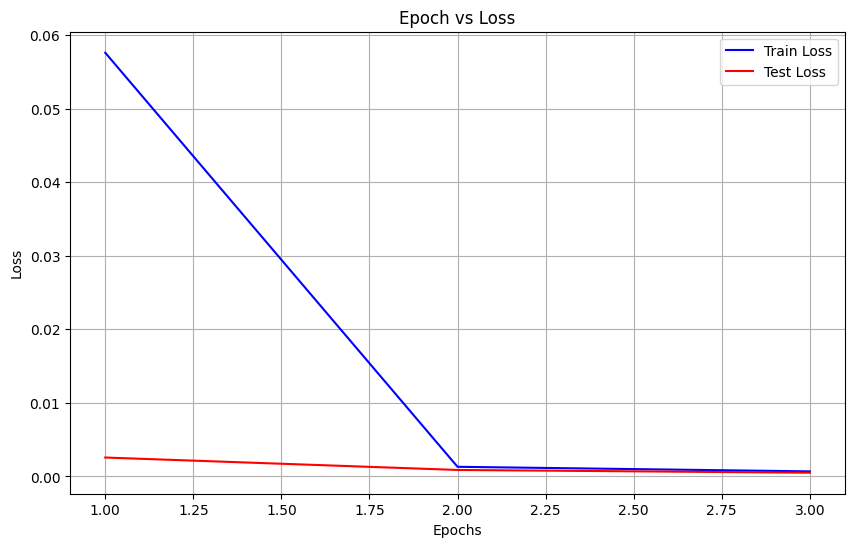

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ETSFORMER yükleme
file_path = "ömerliBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['tarih'] = pd.to_datetime(data['tarih'])
data.set_index('tarih', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)  # Hangi sütunların seçildiğini kontrol edebilirsiniz

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Doğru yazım: __init__
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Doğru yazım: __len__
        return len(self.X)

    def __getitem__(self, index):  # Doğru yazım: __getitem__
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Basit bir ETSFormer modeli (örnek olarak LSTM temelli)
class SimpleETSFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Doğru yazım: __init__
        super(SimpleETSFormer, self).__init__()  # Doğru yazım: __init__
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64
output_dim = 1  # Baraj doluluk yüzdesi

model = SimpleETSFormer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Eğitim ve test kayıplarını saklamak için listeler
train_losses = []
test_losses = []

# Eğitim ve test metriklerini saklamak için listeler
train_mse, train_mape, train_mae, train_rmse, train_r2 = [], [], [], [], []
test_mse, test_mape, test_mae, test_rmse, test_r2 = [], [], [], [], []

# Model eğitimi ve değerlendirme
epochs = 3
for epoch in range(epochs):
    start_train_time = time.time()  # Eğitim başlangıç zamanı
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())

    # Eğitim süresi
    train_time = time.time() - start_train_time

    # Eğitim metriklerini hesapla
    train_mse.append(mean_squared_error(train_actuals, train_preds))
    train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)
    train_mae.append(mean_absolute_error(train_actuals, train_preds))
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals, train_preds)))
    train_r2.append(r2_score(train_actuals, train_preds))

    # Eğitim kaybını kaydetme
    train_losses.append(train_loss / len(train_loader))

    # Test değerlendirme
    start_test_time = time.time()  # Test başlangıç zamanı
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())

    # Test süresi
    test_time = time.time() - start_test_time

    # Test metriklerini hesapla
    test_mse.append(mean_squared_error(test_actuals, test_preds))
    test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)
    test_mae.append(mean_absolute_error(test_actuals, test_preds))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals, test_preds)))
    test_r2.append(r2_score(test_actuals, test_preds))

    # Test kaybını kaydetme
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse[-1]}, Test MSE: {test_mse[-1]}")
    print(f"Train MAPE: {train_mape[-1]}%, Test MAPE: {test_mape[-1]}%")
    print(f"Train MAE: {train_mae[-1]}, Test MAE: {test_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}, Test RMSE: {test_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}, Test R²: {test_r2[-1]}")
    print(f"Training time for epoch {epoch+1}: {train_time:.2f} seconds")
    print(f"Inference time for epoch {epoch+1}: {test_time:.2f} seconds")

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

Index(['tarih', 'sıcaklık', 'çiy', 'nem', 'yağış', 'ruzgar hızı',
       'deniz seviyesi basıncı', 'bulutortusu', 'daylight_duration',
       'doluluk'],
      dtype='object')
            sıcaklık  çiy   nem  yağış  ruzgar hızı  deniz seviyesi basıncı  \
tarih                                                                         
2011-01-01       3.5 -0.3  76.7  0.000         13.1                  1020.3   
2011-01-02       6.5 -1.1  59.2  0.000         18.5                  1015.9   
2011-01-03       6.1  2.8  79.9  0.184         17.7                  1011.7   
2011-01-04       5.0  3.1  87.4  0.467         32.9                  1018.4   
2011-01-05       4.5  0.5  75.8  0.000         31.2                  1023.1   

            bulutortusu  daylight_duration  doluluk  weighted_score  
tarih                                                                
2011-01-01         10.6         556.983333    80.07        179.1080  
2011-01-02         33.2         557.716667    80.07        1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                doluluk   No. Observations:                 3323
Model:                ARIMA(10, 1, 5)   Log Likelihood               -2123.584
Date:                Fri, 03 Jan 2025   AIC                           4279.169
Time:                        07:05:38   BIC                           4376.902
Sample:                    01-01-2011   HQIC                          4314.141
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8032      0.079     10.161      0.000       0.648       0.958
ar.L2         -0.6121      0.080     -7.660      0.000      -0.769      -0.455
ar.L3          0.6732      0.048     13.945      0.0

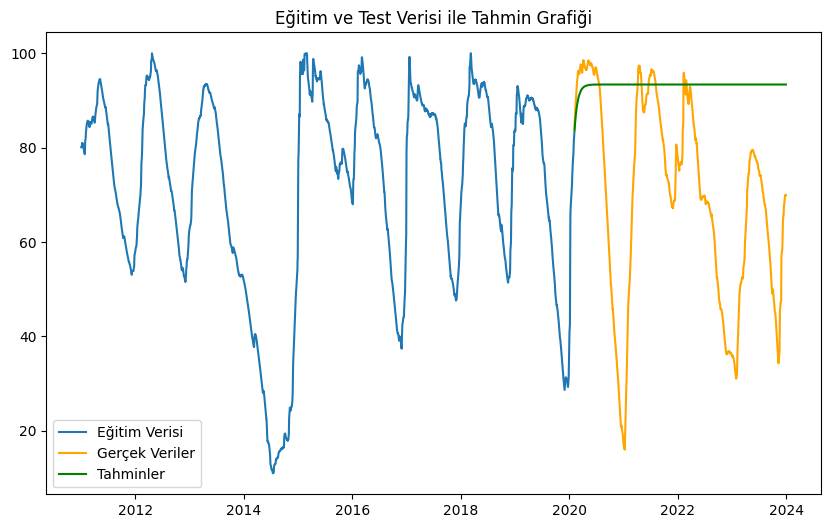

Mean Squared Error (MSE): 1053.7101858926474
Root Mean Squared Error (RMSE): 32.46090241956695
Mean Absolute Error (MAE): 25.200105115355537
Mean Absolute Percentage Error (MAPE): 0.5767301901313908%
R²: -1.250448619260037
Eğitim Süreti: 19.744545221328735 saniye
Çıkarım Süreti: 0.06759023666381836 saniye


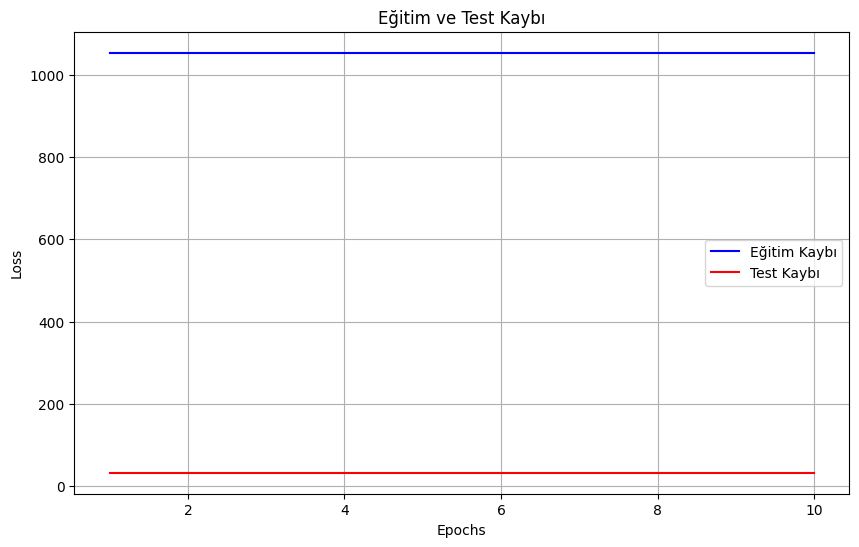

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import time

# ARIMA MODELLEMESI
df = pd.read_excel('ömerliBarajı.xlsx')
print(df.columns)

# Tarih sütununu datetime formatına çevirin
df['tarih'] = pd.to_datetime(df['tarih'])

# Veriyi tarihe göre sıralama
df = df.sort_values(by='tarih')

# Ağırlıkları belirleyin
weights = {
    'sıcaklık': 0.4,

    'çiy': 0.05,
    'nem': 0.1,
    'yağış': 0.7,
    'ruzgar hızı': 0.05,
    'deniz seviyesi basıncı': 0.1,
    'bulutortusu': 0.05,
    'daylight_duration': 0.12
}



# Baraj doluluk yüzdesi ve diğer bağımsız değişkenler
df = df[['tarih', 'sıcaklık', 'çiy', 'nem', 'yağış',
       'ruzgar hızı', 'deniz seviyesi basıncı', 'bulutortusu', 'daylight_duration',
       'doluluk']]

# Ağırlıklı skor hesaplama
df['weighted_score'] = (weights['sıcaklık'] * df['sıcaklık'] +
                        weights['çiy'] * df['çiy'] +
                        weights['nem'] * df['nem'] +
                        weights['yağış'] * df['yağış'] +
                        weights['ruzgar hızı'] * df['ruzgar hızı'] +
                        weights['deniz seviyesi basıncı'] * df['deniz seviyesi basıncı'] +
                        weights['bulutortusu'] * df['bulutortusu'] +
                        weights['daylight_duration'] * df['daylight_duration'])

# Tarihi indeks olarak ayarlayın
df.set_index('tarih', inplace=True)

# Veriye göz atın
print(df.head())

# Baraj doluluk yüzdesi kolonunu hedef olarak seçin
y = df['doluluk']

# Veriyi eğitim ve test setlerine ayırın (shuffle=False)
train, test = train_test_split(y, test_size=0.3, shuffle=False)

# Eğitim ve test zamanlaması
start_time = time.time()  # Eğitim zamanını başlatma

# ARIMA modelini tanımlayın
model = ARIMA(train, order=(10,1,5)) #2 yıla göre tahmin eder 1 fark ile q=2 ise geçmiş hatalarla ilgilenmedir

# Modeli eğitin
model_fit = model.fit()

# Eğitim süreti
end_time = time.time()
training_time = end_time - start_time  # Eğitim süreti hesaplama

# Modelin özetine göz atın
print(model_fit.summary())

# Test verisi üzerinde tahmin yapın
start_inference_time = time.time()  # Çıkarım (inference) zamanını başlatma
predictions = model_fit.forecast(steps=len(test))
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time  # Çıkarım süreti

# Tahminleri görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Eğitim Verisi')
plt.plot(test.index, test, label='Gerçek Veriler', color='orange')
plt.plot(test.index, predictions, label='Tahminler', color='green')
plt.legend()
plt.title('Eğitim ve Test Verisi ile Tahmin Grafiği')
plt.show()

# Modelin başarımını değerlendirelim
mse = mean_squared_error(test, predictions)
mse_rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(test, predictions)  # MAE
mape = mean_absolute_percentage_error(test, predictions)  # MAPE
r2 = r2_score(test, predictions)  # R²

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {mse_rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R²: {r2}')
print(f'Eğitim Süreti: {training_time} saniye')
print(f'Çıkarım Süreti: {inference_time} saniye')

# Sonuçları Excel dosyasına kaydetme
result_df = pd.DataFrame({
    'Gerçek Değerler': test,
    'Tahminler': predictions
})

result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=True)

# Kaybın (Loss) Grafiği
epochs = 10
train_losses = [mse] * epochs
test_losses = [mse_rmse] * epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Eğitim Kaybı", color='blue')
plt.plot(range(1, epochs + 1), test_losses, label="Test Kaybı", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim ve Test Kaybı")
plt.legend()
plt.grid(True)
plt.show()